# Tarea 11: Más pruebas de hipótesis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import multinomial, norm, uniform

# Distribución multinomial

Mendel criaba chícharos de semillas lisas amarillas y de semillas corrugadas verdes. Éstas daban lugar a 4 tipos de descendientes: amarillas lisas, amarillas corrugadas, verdes lisas, y verdes corrugadas. El número de cada una es multinomial con parámetro $p=(p_1,p_2,p_3,p_4)$. De acuerdo a su teoría de herencia este vector de probabilidades es:
$$p=\left(\frac{9}{16},\frac{3}{16},\frac{3}{16},\frac{1}{16}\right)$$

A lo largo de $n=556$ esperimentos observó $x=(315,101,108,32)$. Utiliza la prueba de cociente de verosimilitudes para probar $H_0:p=p_0$ contra $H_A:p\neq p_0$

## Función de verosimilitud

Recordando que la función de densidad de una distribución multinomial queda dada por: 
$$f(x_1,...,x_k;n;p_1,...,p_k)=\frac{n!}{x_1!\cdot ...\cdot x_k!}\cdot p_1^{x_1}\cdot ...\cdot p_k^{x_k}$$

Una función con 4 parámetros, entonces queda dada por:
$$f=\frac{n!}{x_1!x_2!x_3!x_4!}p_1^{x_1}p_2^{x_2}p_3^{x_3}p_4^{x_4}$$

No se determina función de probabilidad conjunta dado que se trata de 1 sólo experimento. Calculando el logaritmo:
$$ln[L(f)] = ln\left[\frac{n!}{x_{1i}!x_{2i}!x_{3i}!x_{4i}!}\right] + ln[p_1^{x_{1i}}p_2^{x_{2i}}p_3^{x_{3i}}p_4^{x_{4i}}]$$

Se observa que la primera parte de la ecuación es una constante $C$, por lo que:
$$ln[L(f)] = C + ln[p_1^{x_{1i}}p_2^{x_{2i}}p_3^{x_{3i}}p_4^{x_{4i}}]$$

Entonces, el cociente de verosimilitud dado por: $ $
$$\lambda = 2\left[C + \sum_{i=1}^4 x_i ln(p_{i\hat\theta}) - C - \sum_{i=1}^4 x_i ln(p_{i\theta})\right]$$
$$\lambda = 2\left[\sum_{i=1}^4 x_i ln(p_{i\hat\theta}) - \sum_{i=1}^4 x_i ln(p_{i\theta})\right]$$

## Memoria de cálculo

**Paso 1**: Calculamos las probabilidades de máxima verosimilitud $p$, que son $p=\left(\frac{315}{556},\frac{101}{556},\frac{108}{556},\frac{32}{556}\right)$

In [2]:
experimentos = 556
observaciones = np.array([315,101,108,32])
p_observada = observaciones / experimentos
p_observada

array([0.56654676, 0.18165468, 0.1942446 , 0.05755396])

**Paso 2**: Evaluamos la verosimilitud

In [3]:
verosimilitud =  np.sum(observaciones * np.log(p_observada))
verosimilitud

-619.5858967532752

**Paso 3**: Evaluamos verosimilitud según $H_0$ dada $p=\left(\frac{9}{16},\frac{3}{16},\frac{3}{16},\frac{1}{16}\right)$

In [4]:
p_h0 = np.array([9,3,3,1]) / 16
verosim_h0 = np.sum(observaciones * np.log(p_h0))
verosim_h0

-619.8236193727744

**Paso 3.b**: Se obtiene el cociente de verosimilitudes de referencia

In [5]:
lambda_ref = 2 * (verosimilitud - verosim_h0)
lambda_ref

0.47544523899841806

**Paso 4**: Obtenemos la distribución de referencia

In [6]:
#Se generan valores de x distirbuidos multinomialmente con probabilidad p
boots_dist = multinomial.rvs(n=experimentos, p=p_h0, size=10_000)
boots_dist[:5]

array([[305, 102, 109,  40],
       [319, 111,  98,  28],
       [306, 115, 103,  32],
       [311,  99, 114,  32],
       [304, 106, 109,  37]])

In [7]:
#Se evalúa en la función de verosimilitud [verosimilitud_h0, verosimilitud_observada]
boots_dist = np.apply_along_axis(func1d=lambda x: np.array([ np.sum(x * np.log(p_h0)), np.sum(x * np.log(x/x.sum())) ]),
                                 axis=1,
                                 arr=boots_dist)
boots_dist[:5]

array([[-639.59864057, -638.99275546],
       [-611.03472106, -609.86481827],
       [-629.71112997, -628.98230097],
       [-624.21806853, -623.52453875],
       [-637.40141599, -637.08532447]])

**Paso 5**: Se calcula el cociente de verosimilitudes

In [8]:
cosciente_vers = 2 * (boots_dist[:,1] - boots_dist[:,0])
cosciente_vers[:5]

array([1.21177023, 2.33980558, 1.45765801, 1.38705956, 0.63218304])

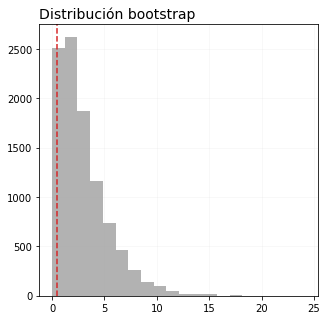

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

#Contenido de figura
ax.hist(x=cosciente_vers, bins=20, color='grey', alpha=0.6)
ax.axvline(x=lambda_ref, ymin=0, ymax=1, color='tab:red', linestyle='--', label='lambda')

#Anotaciones y estilo
ax.set_title("Distribución bootstrap", fontsize=14, loc='left')
ax.grid(alpha=0.1)
#ax.legend()

plt.show()

**Observamos** que $\lambda$ de referencia se encuentra en la zona central de la distribución de referencia. Esto nos da evidancia a favor de la hipótesis nula $H_0$.

Obtenemos el valor p para una prueba de dos colas.

In [10]:
valor_p = np.mean(cosciente_vers > lambda_ref)
valor_p

0.9252

# Distribución uniforme

Sea $X=(X_1,...,X_n)\backsim Uniforme(0,\theta)$ y $T=max(X)$ (el máximo de X), queremos probar: $H_0:\theta=\frac{1}{2}$ contra $H_1:\theta >\frac{1}{2}$.

En esta caso la prueba de Wald no es apropiada pues $T$ no converge a la Normal. Supongamos que decidimos probar la hipótesis rechazando $H_0$ si $T>c$.
* Encuentra la función de poder.
* ¿Qué valor de $c$ correponde a un tamaño de prueba $\alpha =0.05$?
* En una muestra de tamaño $n=20$ con $T=0.48$ ¿cuál es el valor $p$?¿Qué concluyes acerca de $H_0$?
* En una muestra de tamaño $n=20$ con $T=0.52$ ¿cuál es el valor $p$?¿Qué concluyes acerca de $H_0$?

La función de **potencia** queda definida como: $\beta (\theta) = P_{\theta}(\theta > c) = 1 - P_{\theta}(\theta \leq c)$

Recordando que la función de densidad masa de una distribución uniforme (Revisar la [nota](https://tereom.github.io/fundamentos-2022/estimaci%C3%B3n-por-m%C3%A1xima-verosimilitud.html#m%C3%A1xima-verosimilitud-para-observaciones-continuas)) queda dada por:
$$f(\theta)=\frac{1}{\theta}$$

Entonces:
$$P(\theta \leq c) = \int_0^c \frac{1}{\theta}dx = \frac{c}{\theta}$$

Por lo tanto:
$$\beta(\theta) = 1 - P_{\theta}(\theta \leq c) = 1 - P_{\theta}(x_1 \leq c,...,x_n \leq c)$$
$$= 1 - \frac{c}{\theta}\cdot \frac{c}{\theta}\cdot ...\cdot \frac{c}{\theta} = 1 - \left(\frac{c}{\theta}\right)^n$$

Con lo que la **función de potencia**:
$$\beta(\theta) = 1 - \left(\frac{c}{\theta}\right)^n$$

Dado un tamaño de prueba o nivel de significancia $\alpha = \beta(\theta)$, entonces:
$$C = \theta(1 - \alpha)^{1/n}$$

**Caso 1**: $n=20$ con $T=0.48$ para valores $\theta=1/2$, $\alpha=0.05$:

In [21]:
n = 2000
alpha = 0.05
theta = 1/2
T_max = 0.48

#Calculando el valor c
c = theta*(1 - alpha)**(1/n)
c

0.4999871768408393

In [20]:
(uniform.rvs(loc=0, scale=theta, size=20) > T_max).mean()

0.0

In [19]:
simulaciones = np.zeros(shape=(10_000,1))
simulaciones = np.apply_along_axis(func1d=lambda x: (uniform.rvs(loc=0, scale=theta, size=20) > T_max).mean(), axis=1, arr=simulaciones)
simulaciones.mean()

0.0024950000000000003

**Caso 2**: $n=20$ con $T=0.52$ para valores $\theta=1/2$, $\alpha=0.05$:

In [14]:
n = 20
alpha = 0.05
theta = 1/2
T_max = 0.52

#Calculando el valor c
c = theta*(1 - alpha)**(1/n)
c

0.49871931061173486

In [15]:
(uniform.rvs(loc=0, scale=theta, size=20) > T_max).mean()

0.0

In [16]:
simulaciones = np.zeros(shape=(10_000,1))
simulaciones = np.apply_along_axis(func1d=lambda x: (uniform.rvs(loc=0, scale=theta, size=20) > T_max).mean(), axis=1, arr=simulaciones)
simulaciones.mean()

0.0

# Distribución poisson

Sean $X_1,...,X_n\backsim Poisson(\lambda)$,
* Sea $\lambda_0 > 0$ ¿Cuál es la prueba de Wald para $H_0:\lambda = \lambda_0$ y $H_1:\lambda\neq\lambda_0$ 
* Si $\lambda_0=1$, $n=20$, $\alpha=0.05$, simula $X_1,...,X_n\backsim Poisson(\lambda_0)$ y realiza una prueba Wald. Repite 1,000 veces y registra el porcentaje de veces que rechazas $H_0$, ¿qué tan cerca te queda el error tipo 1 de $\alpha=0.05$?